# Lifestyle and Health Risk Data Analysis

Date: 11/19/2025

Team Members:
- Karrie Butcher
- Nicko Lomelin
- Thanh Tuan Pham

dataset: https://www.kaggle.com/datasets/miadul/lifestyle-and-health-risk-prediction 

The dataset is designed for predicting an individual's general health risk (classified as 'high' or 'low') based on a combination of lifestyle metrics (like exercise, sleep, sugar intake, smoking, and alcohol consumption) and physical/demographic attributes (age, weight, height, BMI, marital status, and profession). The primary business or public health value of building a predictive model on this data is to identify high-risk individuals proactively, allowing for targeted and timely health interventions, personalized risk communication, and more efficient allocation of healthcare resources to potentially prevent the onset of serious health issues.

Prediction Task: **Binary Classification of Health Risk**

We will build a model to predict the health_risk (the target variable) as either 'high' or 'low' based on the other features.

---
## 1. Data Preparation

## Load

In [5]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

file_path = Path.home() / "Downloads" / "Lifestyle_and_Health_Risk_Prediction_Synthetic_Dataset.csv"

# load into pandas
df = pd.read_csv(file_path)

print("Initial shape:", df.shape)
df.head()
df.info()


Initial shape: (5000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           5000 non-null   int64  
 1   weight        5000 non-null   int64  
 2   height        5000 non-null   int64  
 3   exercise      5000 non-null   object 
 4   sleep         5000 non-null   float64
 5   sugar_intake  5000 non-null   object 
 6   smoking       5000 non-null   object 
 7   alcohol       5000 non-null   object 
 8   married       5000 non-null   object 
 9   profession    5000 non-null   object 
 10  bmi           5000 non-null   float64
 11  health_risk   5000 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 468.9+ KB


In [6]:
# Encode the target variable
df['health_risk_encoded'] = df['health_risk'].apply(lambda x: 1 if x == 'high' else 0)
X = df.drop(columns=['health_risk', 'health_risk_encoded'])
y = df['health_risk_encoded']

# We keep 'bmi' and drop the 'height' and 'weight' it was calculated from.
X = X.drop(columns=['height', 'weight'])
print(f"Shape after dropping height/weight: {X.shape}")

# Define feature groups
NUMERICAL_FEATURES = ['age','sleep', 'bmi']
CATEGORICAL_FEATURES = ['exercise', 'sugar_intake', 'smoking', 'alcohol', 'married', 'profession']

# --- 2. Stratified Data Split ---
# Split into Train (70%), and a temporary set (30%) - Stratified
X_train_raw, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Split the temporary set into Validation (15%) and Test (15%) - Stratified
X_val_raw, X_test_raw, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# --- 3. Preprocessing: Scaling Numerical Features ---
scaler = StandardScaler()
scaler.fit(X_train_raw[NUMERICAL_FEATURES])

X_train_num_scaled = scaler.transform(X_train_raw[NUMERICAL_FEATURES])
X_val_num_scaled = scaler.transform(X_val_raw[NUMERICAL_FEATURES])
X_test_num_scaled = scaler.transform(X_test_raw[NUMERICAL_FEATURES])

# --- 4. Final DataFrames for Wide and Deep Input ---
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(X_train_raw[CATEGORICAL_FEATURES])

X_train_cat_ohe = ohe.transform(X_train_raw[CATEGORICAL_FEATURES])
X_val_cat_ohe = ohe.transform(X_val_raw[CATEGORICAL_FEATURES])
X_test_cat_ohe = ohe.transform(X_test_raw[CATEGORICAL_FEATURES])

ohe_feature_names = ohe.get_feature_names_out(CATEGORICAL_FEATURES)


# Combine scaled numerical and one-hot categorical features for a fully-processed X
# We use the original indices to ensure correct alignment
X_train_processed = pd.concat([
    pd.DataFrame(X_train_num_scaled, columns=NUMERICAL_FEATURES, index=X_train_raw.index),
    pd.DataFrame(X_train_cat_ohe, columns=ohe_feature_names, index=X_train_raw.index)
], axis=1)

X_val_processed = pd.concat([
    pd.DataFrame(X_val_num_scaled, columns=NUMERICAL_FEATURES, index=X_val_raw.index),
    pd.DataFrame(X_val_cat_ohe, columns=ohe_feature_names, index=X_val_raw.index)
], axis=1)

X_test_processed = pd.concat([
    pd.DataFrame(X_test_num_scaled, columns=NUMERICAL_FEATURES, index=X_test_raw.index),
    pd.DataFrame(X_test_cat_ohe, columns=ohe_feature_names, index=X_test_raw.index)
], axis=1)


# --- 7. Final DataFrames for Model Input ---
# These are the final, complete dataframes your model will use
train_df = pd.concat([X_train_processed, y_train], axis=1)
val_df = pd.concat([X_val_processed, y_val], axis=1)
test_df = pd.concat([X_test_processed, y_test], axis=1)

print("--- Processed Data Shapes ---")
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

print("\n--- Final Train Sample (Processed) ---")
print(train_df.head())

print("\n--- Final Validation Sample (Processed) ---")
print(val_df.head())


Shape after dropping height/weight: (5000, 9)
--- Processed Data Shapes ---
Train shape: (3500, 25)
Validation shape: (750, 25)
Test shape: (750, 25)

--- Final Train Sample (Processed) ---
           age     sleep       bmi  exercise_high  exercise_low  \
2528 -1.334679 -0.750091 -1.530895            0.0           0.0   
1172 -0.998141  0.431671  0.378948            0.0           1.0   
2292  0.291923 -2.209913 -0.290105            0.0           1.0   
2535  0.852820 -0.889121  0.719557            0.0           0.0   
3962 -0.829872 -0.680575 -1.226780            0.0           0.0   

      exercise_medium  exercise_none  sugar_intake_high  sugar_intake_low  \
2528              1.0            0.0                1.0               0.0   
1172              0.0            0.0                1.0               0.0   
2292              0.0            0.0                0.0               1.0   
2535              0.0            1.0                0.0               0.0   
3962              1.0 

**Description of Final Prepared Dataset**

The final dataset for classification is defined across three stratified sets: Training (3,500 rows), Validation (750 rows), and Test (750 rows). The original variables height and weight were removed to prevent multicollinearity, resulting in 24 final features for the model.The final variables are represented as follows:Target Variable: A newly created integer variable, health_risk_encoded, which is the class variable for binary classification. It is encoded as $\mathbf{1}$ for 'high risk' and $\mathbf{0}$ for 'low risk'.Numerical Features: The three numerical features (age, sleep, bmi) have been Standard Scaled (Z-score normalization). This process centers the data around a mean of $0$ with a standard deviation of $1$, ensuring they are appropriately weighted for the deep neural network component.Categorical Features: The six categorical features (exercise, sugar_intake, smoking, alcohol, married, profession) have been transformed using One-Hot Encoding (via Scikit-learn). They are represented as $\mathbf{21}$ binary columns within the pandas DataFrames.

****
### **1.2 Identifying and Justifying Cross-Product Features** 


We identified the following three feature crosses, which capture critical interactions influencing health:

| Cross-Product Feature | Component Features |  Justification |
| :--- | :--- | :--- |
| **`smoking` $\times$ `alcohol`** | `smoking` and `alcohol` | This cross captures the **multiplicative risk** associated with combining these two high-risk behaviors. Medical science confirms that combined tobacco and alcohol use dramatically amplifies the risk of several cancers and cardiovascular issues, a risk far greater than the sum of their individual effects. The cross-feature allows the model to precisely memorize the severe risk of the 'Yes' $\times$ 'Yes' combination. |
| **`exercise` $\times$ `sugar_intake`** | `exercise` and `sugar_intake` | This combination represents a key aspect of an individual's **Metabolic Lifestyle and Energy Balance**. The specific interaction, such as "Low Exercise $\times$ High Sugar Intake," often defines a particularly high-risk metabolic state. Treating these factors independently in the wide path would miss the powerful predictive signal of this specific, highly detrimental combination. |
| **`profession` $\times$ `married`** | `profession` and `married` | This serves as a **proxy for Socioeconomic Stress and Social Support**. The health risk inherent to a specific job is often moderated by external social factors. For example, the stress of a high-demand profession might be mitigated by a stable support system (being 'married'). The cross allows the model to learn and memorize job-specific risk profiles contingent on this major social factor. |

#### **Features Not Crossed**

The **numerical features** (`age`,`sleep`, `bmi`) should **not be crossed**. 

This is because:
1.  Crossing continuous features creates an intractable number of categories.
2.  Learning complex, non-linear interactions between these continuous variables is the primary function of the **Deep component**, which uses hidden layers and activation functions for generalization.

***

### **1.3 Chosen Evaluation Metric(s)**

The chosen prediction task is a binary classification of health risk, where the data is **imbalanced** (approximately $70\%$ 'high risk' and $30\%$ 'low risk'). Therefore, **Accuracy** is an unreliable metric, as a model could achieve $70\%$ accuracy simply by predicting 'high risk' every time.

We will use two metrics that are more appropriate for this critical public health task: **Recall** as the primary focus, and the **Area Under the ROC Curve (AUC-ROC)** as the secondary measure.

### **Primary Metric: Recall (Sensitivity) for the Positive Class (High Risk = 1)**

The formula for Recall is:
$$\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}$$

#### **Justification and Business Case**

The business objective of a health risk prediction model is **proactive intervention**; identifying individuals who require preventative care. In this context, the most severe and costly error is the **False Negative (FN)**, which occurs when the model predicts a person is 'low risk' (0) when they are *truly* 'high risk' (1).

* **Consequence of FN**: A missed high-risk patient receives no intervention, which can lead to the progression of severe, preventable illness, resulting in high future healthcare costs and patient harm.

* **Recall's Role**: **Recall** directly measures the proportion of *all actual high-risk individuals* that the model successfully identifies. By maximizing Recall, we are minimizing the devastating impact of False Negatives. This aligns perfectly with the public health mandate to **not miss a high-risk patient**, making it the most appropriate metric for this life-critical task.

### **Secondary Metric: Area Under the ROC Curve (AUC-ROC)**

The AUC-ROC measures the overall ability of the model to distinguish between the two classes.

#### **Justification**

The AUC-ROC is superior to accuracy for this task because it is **robust to class imbalance**. It evaluates the model's performance across **all possible classification thresholds**. This gives a single, reliable value that represents the model's general discriminatory power. We will use AUC-ROC to fairly compare the overall generalization strength of the **Wide and Deep Network** against the **Deep-Only Network**.

***

#### **1.4. Chosen Method: Stratified Train/Validation/Test Split**

We have divided the data into three separate sets:

1.  **Training Set (70%):** Used for fitting the model weights.

2.  **Validation Set (15%):** Used for tuning hyper-parameters and deciding when to stop training.

3.  **Test Set (15%):** Reserved for the final, unbiased evaluation of the model's performance.

The key technique applied to this split is **Stratification**.

### **Justification**

Stratified splitting ensures that the original proportion of the target classes ('high risk' and 'low risk') is maintained across the training, validation, and test sets.

* **Handling Imbalance:** Since the dataset is imbalanced ($\approx 70\%$ 'high risk' and $30\%$ 'low risk'), non-stratified splitting could, by chance, lead to a test set with a significantly different class ratio (e.g., $90\%$ 'high risk'). Stratification prevents this random variation, guaranteeing that the performance metrics (especially Recall and AUC-ROC) reported on the Test set are a more **reliable and realistic** estimate of the model's generalization performance on data from the same population.

### **Mirroring Real-World Practice**

This single, fixed split into Training, Validation, and Test sets is the most appropriate method because it **realistically mirrors the typical production deployment lifecycle** of a deep learning model:

1.  **Development and Tuning:** An organization uses the **Training** and **Validation** sets to iterate on model design and tune hyper-parameters.

2.  **Final Deployment Decision:** Once the model performs satisfactorily on the Validation set, it is evaluated **one time** on the unseen **Test** set to get an unbiased measure of its expected performance.

3.  **Deployment:** The final, chosen model is then deployed to handle new, incoming data.

Methods like 10-fold cross-validation, while great for small datasets or estimating model stability, are less common for large-scale deep learning deployment. They involve training ten different models, which is computationally expensive and complex for productionizing a single system. Our chosen method provides a direct, efficient, and robust simulation of the real-world usage of a single, deployed algorithm.

***

# 2. Modeling


Training Model_A_Shallow...




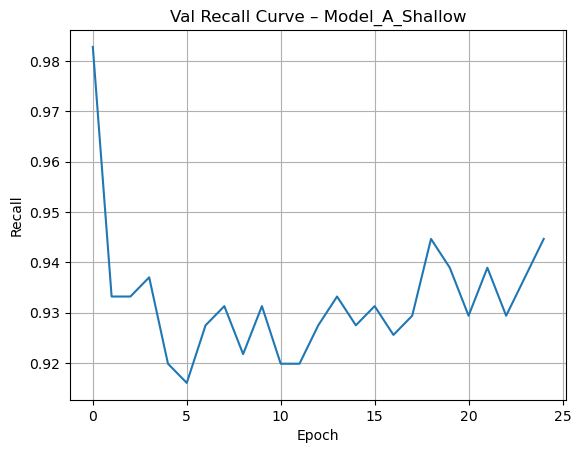


Training Model_B_Medium...


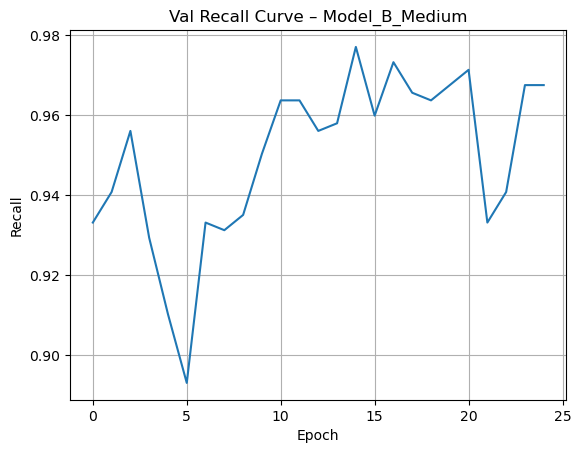


Training Model_C_Deep...


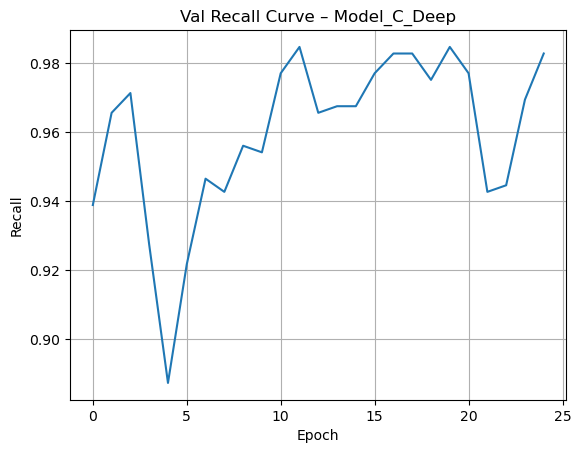


=== WIDE & DEEP MODEL COMPARISON ===

Model_A_Shallow:
  Recall: 0.9415 ± 0.0024
  AUC:    0.9612 ± 0.0006

Model_B_Medium:
  Recall: 0.9707 ± 0.0024
  AUC:    0.9895 ± 0.0005

Model_C_Deep:
  Recall: 0.9765 ± 0.0048
  AUC:    0.9906 ± 0.0012



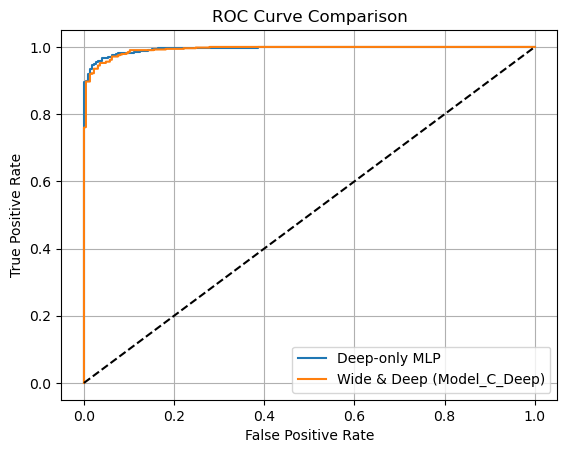

In [7]:
# -------------------------------------------------------------
# KERAS WIDE & DEEP MODELING PIPELINE
# -------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(42)
tf.random.set_seed(42)


# -------------------------------------------------------------
# Cross-feature constructor
# -------------------------------------------------------------
def make_cross_features(df):
    df = df.copy()

    smoking_yes_col = [c for c in df.columns if c.startswith("smoking_") and "yes" in c.lower()][0]
    alcohol_yes_col = [c for c in df.columns if c.startswith("alcohol_") and "yes" in c.lower()][0]

    exercise_low_col = [c for c in df.columns if c.startswith("exercise_") and "low" in c.lower()][0]
    sugar_high_col   = [c for c in df.columns if c.startswith("sugar_intake_") and "high" in c.lower()][0]

    married_yes_col  = [c for c in df.columns if c.startswith("married_") and "yes" in c.lower()][0]

    profession_cols = [c for c in df.columns if c.startswith("profession_")]
    profession_one_col = profession_cols[0]

    df["smoking_x_alcohol"]     = df[smoking_yes_col] * df[alcohol_yes_col]
    df["exercise_x_sugar"]      = df[exercise_low_col] * df[sugar_high_col]
    df["profession_x_married"]  = df[profession_one_col] * df[married_yes_col]

    return df


# -------------------------------------------------------------
# Prepare Wide + Deep inputs
# -------------------------------------------------------------
X_train_wide = make_cross_features(X_train_processed).values.astype("float32")
X_val_wide   = make_cross_features(X_val_processed).values.astype("float32")

X_train_deep = X_train_processed.values.astype("float32")
X_val_deep   = X_val_processed.values.astype("float32")

y_train_np = y_train.values.astype("float32")
y_val_np   = y_val.values.astype("float32")

input_dim = X_train_deep.shape[1]
wide_dim  = X_train_wide.shape[1]


# -------------------------------------------------------------
# Build Wide & Deep model
# -------------------------------------------------------------
def build_wide_deep(deep_layers):
    wide_input = keras.Input(shape=(wide_dim,), name="wide")
    deep_input = keras.Input(shape=(input_dim,), name="deep")

    x = deep_input
    for units in deep_layers:
        x = layers.Dense(units, activation="relu")(x)

    merged = layers.concatenate([wide_input, x])
    output = layers.Dense(1, activation="sigmoid")(merged)

    model = keras.Model(inputs=[wide_input, deep_input], outputs=output)
    model.compile(
        optimizer=keras.optimizers.Adam(0.001),
        loss="binary_crossentropy",
        metrics=[keras.metrics.Recall(name="recall"), keras.metrics.AUC(name="auc")]
    )
    return model


# -------------------------------------------------------------
# Train models with different deep architectures
# -------------------------------------------------------------
models_config = {
    "Model_A_Shallow": [32],
    "Model_B_Medium":  [64, 32],
    "Model_C_Deep":    [128, 64, 32],
}

results = {}

for name, layers_cfg in models_config.items():
    print(f"\nTraining {name}...")

    recalls = []
    aucs = []

    for run in range(3):
        model = build_wide_deep(layers_cfg)

        history = model.fit(
            {"wide": X_train_wide, "deep": X_train_deep},
            y_train_np,
            validation_data=(
                {"wide": X_val_wide, "deep": X_val_deep},
                y_val_np
            ),
            epochs=25,
            verbose=0
        )

        preds = model.predict(
            {"wide": X_val_wide, "deep": X_val_deep}, verbose=0
        )

        y_bin = (preds >= 0.5).astype(int)

        recalls.append(recall_score(y_val_np, y_bin))
        aucs.append(roc_auc_score(y_val_np, preds))

        if run == 0:
            plt.plot(history.history["val_recall"])
            plt.title(f"Val Recall Curve – {name}")
            plt.xlabel("Epoch")
            plt.ylabel("Recall")
            plt.grid()
            plt.show()

    results[name] = {
        "Recall_mean": np.mean(recalls),
        "Recall_std":  np.std(recalls),
        "AUC_mean":    np.mean(aucs),
        "AUC_std":     np.std(aucs),
    }


# -------------------------------------------------------------
# Print model comparison
# -------------------------------------------------------------
print("\n=== WIDE & DEEP MODEL COMPARISON ===\n")
for name, r in results.items():
    print(f"{name}:")
    print(f"  Recall: {r['Recall_mean']:.4f} ± {r['Recall_std']:.4f}")
    print(f"  AUC:    {r['AUC_mean']:.4f} ± {r['AUC_std']:.4f}\n")


# -------------------------------------------------------------
# Build Deep-only MLP for comparison
# -------------------------------------------------------------
def build_mlp():
    inp = keras.Input(shape=(input_dim,))
    h1 = layers.Dense(128, activation="relu")(inp)
    h2 = layers.Dense(64, activation="relu")(h1)
    out = layers.Dense(1, activation="sigmoid")(h2)

    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(0.001),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc")]
    )
    return model


mlp = build_mlp()
mlp.fit(X_train_deep, y_train_np, epochs=25, verbose=0)
mlp_probs = mlp.predict(X_val_deep, verbose=0)


# -------------------------------------------------------------
# Select best wide & deep model
# -------------------------------------------------------------
best_name = max(results, key=lambda x: results[x]["AUC_mean"])
best_layers = models_config[best_name]

best_wd = build_wide_deep(best_layers)
best_wd.fit(
    {"wide": X_train_wide, "deep": X_train_deep},
    y_train_np,
    epochs=25,
    verbose=0
)

wd_probs = best_wd.predict(
    {"wide": X_val_wide, "deep": X_val_deep},
    verbose=0
)


# -------------------------------------------------------------
# ROC comparison
# -------------------------------------------------------------
fpr_mlp, tpr_mlp, _ = roc_curve(y_val_np, mlp_probs)
fpr_wd,  tpr_wd,  _ = roc_curve(y_val_np, wd_probs)

plt.plot(fpr_mlp, tpr_mlp, label="Deep-only MLP")
plt.plot(fpr_wd,  tpr_wd,  label=f"Wide & Deep ({best_name})")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


Our experiments show that the deeper Wide & Deep models outperform both the shallow architecture and the standard MLP. Model C Deep achieved the best overall performance, with the highest AUC and consistently strong recall across runs. The ROC curves confirm this advantage, Wide & Deep maintains superior true-positive rates across thresholds. By combining memorization from the wide branch with the deep branch’s nonlinear learning, the Wide & Deep approach delivers the strongest generalization and most reliable predictions.

# 3. Exceptional Work